<a href="https://colab.research.google.com/github/mnguyen1901/RSNA_mammogram/blob/main/Vit_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict
import torch
from tqdm.notebook import tqdm
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from itertools import product

from sklearn.metrics import f1_score
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import Resize
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler
from torch import nn
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

from transformers import ViTFeatureExtractor, ViTConfig, ViTForImageClassification, ViTModel, get_scheduler

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
os.listdir()

['Untitled (1)',
 'Untitled',
 'Sentence Encoder.ipynb',
 'RadStudies_clusterNumber.ipynb',
 'COVID cases.ipynb',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'Untitled0.ipynb',
 'vit_saved',
 'X_Vin_eq.pt',
 'X_RSNA_eq.pt',
 'X_CBIS_eq.pt',
 'y_RSNA.pt',
 'Copy of Vit-224.ipynb']

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
pd.read_csv("test.csv")

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [ ]:
train_df = pd.read_csv("train.csv")
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
# Moved to PC due to memory constraint but expected results are showed below
"""
def histogram_equalization(img):
    img = img.numpy()
    m = int(np.max(img))
    hist = np.histogram(img, bins=m+1, range=(0, m+1))[0]
    hist = hist/img.size
    cdf = np.cumsum(hist)
    s_k = (255 * cdf)
    img_new = np.array([s_k[i] for i in img.ravel()]).reshape(img.shape)
    return img_new

def process_img(X):
    X_new = []
    for pair in tqdm(X):
        cc = histogram_equalization(pair[0])
        cc = (cc/255-0.5)/0.5

        mlo = histogram_equalization(pair[1])
        mlo = (mlo/255-0.5)/0.5

        pair = torch.tensor([cc, mlo])
        X_new.append(pair)

    X_new = torch.stack(X_new)
    return X_new

X = process_img(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

vin = pd.read_pickle("mass_only_VIN.pkl")
y_vin = torch.ones(vin.size()[0])

cbis = pd.read_pickle("mass_only_CBIS.pkl")
y_cbis = torch.ones(cbis.size()[0])

X_vin = process_img(vin)
X_cbis = process_img(cbis)
"""

'\ndef histogram_equalization(img):\n    img = img.numpy()\n    m = int(np.max(img))\n    hist = np.histogram(img, bins=m+1, range=(0, m+1))[0]\n    hist = hist/img.size\n    cdf = np.cumsum(hist)\n    s_k = (255 * cdf)\n    img_new = np.array([s_k[i] for i in img.ravel()]).reshape(img.shape)\n    return img_new\n\ndef process_img(X):\n    X_new = []\n    for pair in tqdm(X):\n        cc = histogram_equalization(pair[0])\n        cc = (cc/255-0.5)/0.5\n\n        mlo = histogram_equalization(pair[1])\n        mlo = (mlo/255-0.5)/0.5\n\n        pair = torch.tensor([cc, mlo])\n        X_new.append(pair)\n\n    X_new = torch.stack(X_new)\n    return X_new\n\nX = process_img(X)\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)\n\nvin = pd.read_pickle("mass_only_VIN.pkl")\ny_vin = torch.ones(vin.size()[0])\n\ncbis = pd.read_pickle("mass_only_CBIS.pkl")\ny_cbis = torch.ones(cbis.size()[0])\n\nX_vin = process_img(vin)\nX_cbis = process_img(cbis)\n'

Before and after histogram equalization

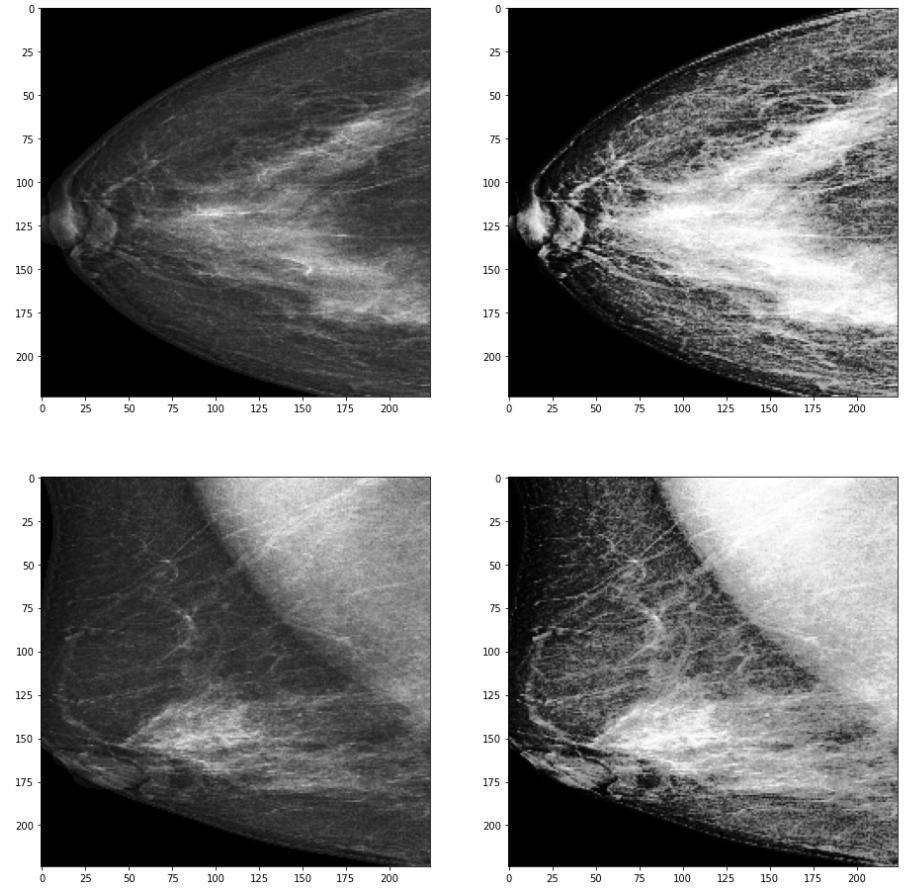

In [ ]:
X_RSNA = torch.load("X_RSNA_eq.pt")
X_Vin = torch.load("X_Vin_eq.pt")
X_CBIS = torch.load("X_CBIS_eq.pt")

y_RSNA = torch.load("y_RSNA.pt")


X_train, X_val, y_train, y_val = train_test_split(X_RSNA, y_RSNA, test_size=0.1, random_state=42)

y_Vin = torch.ones(X_Vin.size()[0])
y_CBIS = torch.ones(X_CBIS.size()[0])

print(X_train.size())
print(X_Vin.size())
print(X_CBIS.size())

X_train = torch.cat((X_train, X_Vin, X_CBIS), dim=0)
y_train = torch.cat((y_train, y_Vin, y_CBIS))

print(X_train.size())

torch.Size([29201, 2, 224, 224])
torch.Size([609, 2, 224, 224])
torch.Size([1043, 2, 224, 224])
torch.Size([30853, 2, 224, 224])


In [ ]:
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandAugment(num_ops=2, magnitude=15),
    transforms.ToTensor()
])

In [ ]:
class TransformedDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        image = self.X[index]
        cc = image[0]
        mlo = image[1]

        cc = cc.expand(3,-1,-1)
        mlo = mlo.expand(3,-1,-1)
    
        cc = self.transform(cc)
        mlo = self.transform(mlo)  
        label = self.y[index]
        
        return (cc, mlo, label)

In [ ]:
def pf1(labels, preds, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = sum(labels)
    ctp = sum(preds[labels==1])
    cfp = sum(preds[labels==0])
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

In [ ]:
def evaluate(model, dataloader):
    predictions = []
    y_true = []
    loss_epoch = 0

    model.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            cc = batch[0].to(device)
            mlo = batch[1].to(device)
            y = batch[2].to(device)
            outputs = model(cc, mlo)
            loss = model.loss_fn(outputs, y)
                 
            loss_epoch += loss.item()
            predictions += torch.squeeze(outputs).tolist()
            y_true += torch.squeeze(y).tolist()
    
    y_proba = nn.Sigmoid()(torch.Tensor(predictions)).numpy()

    # Metrics
    f1 = pf1(np.array(y_true).astype(int), y_proba)

    return loss_epoch/len(dataloader), f1, y_proba, y_true

In [ ]:
def train(model, epochs, train_dataloader, val_dataloader, lr):
    num_training_steps = epochs * len(train_dataloader)
    progress_bar = tqdm(range(num_training_steps))

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    lr_scheduler = get_scheduler(name="cosine", 
                                optimizer=optimizer, 
                                num_warmup_steps=5000, 
                                num_training_steps=num_training_steps)
    
    best_loss = 1e5
    best_f1 = 0
    no_improvement = 0
    total_loss_train = []
    total_loss_val = []

    print("Epoch", " "*5, 
        "Train loss", " "*5,
        "Val loss", " "*5,
        "Val F1")

    model.train()
    for epoch in range(epochs):
        loss_epoch_train = 0

        for batch in train_dataloader:
            cc = batch[0].to(device)
            mlo = batch[1].to(device)
            y = batch[2].to(device)
            outputs = model(cc, mlo)
            
            loss = model.loss_fn(outputs, y)
            loss.backward()
            torch.cuda.empty_cache()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
            progress_bar.update(1)
            loss_epoch_train += loss.item()
            
        total_loss_train.append(loss_epoch_train/len(train_dataloader))   
        loss_epoch_val, f1_epoch_val, y_proba, y_true = evaluate(model, val_dataloader)
        total_loss_val.append(loss_epoch_val)

        print(epoch, " "*(10-len(str(epoch))),
            str(total_loss_train[-1])[:6], " "*9,
            str(loss_epoch_val)[:6], " "*7,
            str(f1_epoch_val)[:4])
        
        if loss_epoch_val < best_loss:
            best_loss = loss_epoch_val
            no_improvement = 0
        else:
            no_improvement += 1

        # if f1_epoch_val > best_f1:
        #     best_f1 = f1_epoch_val
        #     torch.save(model.state_dict(), "vit_saved/vit.pt")
        
        # Early stop if there is no improvement to validation loss after a certain number of consecutive epochs
        # if no_improvement == 5:
        #     break
        
    return total_loss_train, total_loss_val, y_proba, y_true

In [ ]:
model_names = ["google/vit-base-patch16-224-in21k", "google/vit-base-patch32-224-in21k", 
               "google/vit-large-patch16-224-in21k", "google/vit-large-patch32-224-in21k"]

In [ ]:
print(X_val.size())
print(y_val.size())

torch.Size([3245, 2, 224, 224])
torch.Size([3245])


In [ ]:
train_data = TransformedDataset(X_train.float(), y_train.float().unsqueeze(-1), transform=data_transform)
val_data = TransformedDataset(X_val.float(), y_val.float().unsqueeze(-1), transform=data_transform)

# train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=128, pin_memory=True, num_workers=2)

y_train_np = torch.squeeze(y_train).cpu().detach().numpy()
weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)
print(weights)

[0.53987891 6.76897762]


In [ ]:
for batch in train_dataloader: 
    break

batch[2].size()

torch.Size([128, 1])

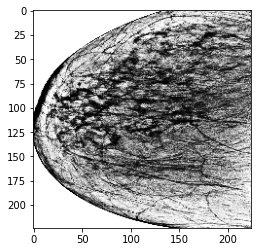

In [ ]:
plt.imshow(batch[0][10][0], cmap="gray")

In [ ]:
class vit2x(nn.Module):
    def __init__(self, model_name):
        super(vit2x, self).__init__()

        self.vit = ViTModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(768, 1)
        )

    def forward(self, cc, mlo):
        cc_output = self.vit(cc)[0][:,0,:]
        mlo_output = self.vit(mlo)[0][:,0,:]

        cc = (cc_output/255-0.5)/0.5
        mlo = (mlo_output/255-0.5)/0.5

        outputs = self.classifier(cc_output + mlo_output)

        return outputs

In [ ]:
model_name_or_path = "google/vit-base-patch16-224-in21k"

vit = vit2x(model_name_or_path)
# vit = ViTForImageClassification.from_pretrained(model_name_or_path, num_labels=1)

In [ ]:
batch[0].size()

torch.Size([128, 3, 224, 224])

In [ ]:
out = vit(batch[0], batch[1])

In [ ]:
len(train_dataloader)*200*0.1

4840.0

In [ ]:
"""
For 2/18:
- Test run with base model and,
- Add weight decay and warmup

"""
EPOCHS = 200

vit.to(device)
vit.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weights[1]/weights[0]]).to(device))

In [ ]:
vit.loss_fn(out.to(device), batch[2].to(device))

tensor(1.5519, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
train_loss, val_loss, y_proba, y_true = train(vit, EPOCHS, train_dataloader, val_dataloader, 1e-4)

del vit

  0%|          | 0/48400 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1


In [ ]:
y_proba

"The only difference to the original ViT model (13) in our paper is
that we drop the hidden layer in the head, as empirically it does not lead to more accurate models and often
results in optimization instabilities: when pre-training on ImageNet-1k we include both models with and
without hidden layer, when pre-training on ImageNet-21k we always drop the hidden layer"

==> Can consider setting num_hidden_layers=0

In [ ]:
def fine_tuning_params(num_ops=2, magnitude=9, hidden_dropout=0.1, attention_dropout=0.1, attention_heads=12, lr=1e-4):
    data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandAugment(num_ops=num_ops, magnitude=magnitude),
        transforms.ToTensor()
    ])

    train_data = TransformedDataset(X_train, y_train.float().unsqueeze(-1), transform=data_transform)
    val_data = TransformedDataset(X_val, y_val.float().unsqueeze(-1), transform=data_transform)

    # train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, batch_size=BATCH, pin_memory=True, num_workers=2)
    val_dataloader = DataLoader(val_data, batch_size=BATCH, pin_memory=True, num_workers=2)

    model = ViTForImageClassification.from_pretrained(model_name_or_path, 
                                                      num_labels=1,
                                                      hidden_dropout_prob=0.1, 
                                                      attention_probs_dropout_prob=0.2,
                                                      num_attention_heads = 16,
                                                      num_hidden_layers=0)

    model.to(device)
    model.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weights[1]/weights[0]]).to(device))

    print("\n")
    print("Num_op =", num_ops, 
          "| Mag =", magnitude, 
          "| Hidden dropout =",hidden_dropout, 
          "| Attention dropout =", attention_dropout, 
          "| Attention heads =", attention_heads, 
          "| LR =", lr)
    y_proba, y_true = train(model, EPOCHS, train_dataloader, val_dataloader, lr)

    del model

In [ ]:
#num_ops,  magnitude
augmentation_params = [(0,0), (2,10), (2,15), (2,20)]

#model params
hidden_dropout_params = [0.1, 0.2]
attention_dropout_params= [0.1, 0.2]
attention_heads_params = [8, 12]
model_params = product(hidden_dropout_params, attention_dropout_params, attention_heads_params)

LR_params = [1e-4, 3e-4, 1e-3]

EPOCHS = 50
BATCH = 256

for num_ops, magnitude in augmentation_params:
    for hidden_dropout, attention_dropout, attention_heads in model_params:
        for lr in LR_params:
            fine_tuning_params(num_ops, magnitude, hidden_dropout, attention_dropout, attention_heads, lr)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 8 | LR = 1e-05


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3579           1.3491         0.03
1           1.3577           1.3488         0.03
2           1.3574           1.3487         0.03
3           1.3573           1.3487         0.03
4           1.3572           1.3487         0.03
5           1.3572           1.3487         0.03
6           1.3572           1.3487         0.03
7           1.3572           1.3488         0.03
8           1.3572           1.3488         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 8 | LR = 3e-05


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3574           1.3488         0.03
1           1.3573           1.3489         0.03
2           1.3573           1.3489         0.03
3           1.3573           1.3489         0.03
4           1.3573           1.3489         0.03
5           1.3573           1.3489         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 8 | LR = 0.0001


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3587           1.3492         0.03
1           1.3577           1.3492         0.03
2           1.3577           1.3492         0.03
3           1.3577           1.3492         0.03
4           1.3577           1.3492         0.03
5           1.3577           1.3492         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 8 | LR = 0.0003


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3584           1.3487         0.03
1           1.3580           1.3487         0.03
2           1.3579           1.3487         0.03
3           1.3579           1.3487         0.03
4           1.3579           1.3487         0.03
5           1.3578           1.3487         0.03
6           1.3578           1.3487         0.03
7           1.3578           1.3488         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 12 | LR = 1e-05


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3590           1.3491         0.03
1           1.3577           1.3488         0.03
2           1.3574           1.3487         0.03
3           1.3573           1.3487         0.03
4           1.3572           1.3487         0.03
5           1.3572           1.3487         0.03
6           1.3572           1.3487         0.03
7           1.3572           1.3488         0.03
8           1.3572           1.3488         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 12 | LR = 3e-05


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3599           1.3490         0.03
1           1.3574           1.3487         0.03
2           1.3573           1.3488         0.03
3           1.3573           1.3489         0.03
4           1.3573           1.3489         0.03
5           1.3573           1.3489         0.03
6           1.3573           1.3489         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 12 | LR = 0.0001


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3578           1.3491         0.03
1           1.3577           1.3492         0.03
2           1.3577           1.3492         0.03
3           1.3577           1.3492         0.03
4           1.3577           1.3492         0.03
5           1.3577           1.3492         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0 | Attention heads = 12 | LR = 0.0003


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3595           1.3487         0.03
1           1.3580           1.3487         0.03
2           1.3579           1.3487         0.03
3           1.3579           1.3487         0.03
4           1.3579           1.3487         0.03
5           1.3578           1.3487         0.03


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['encoder.layer.10.intermediate.dense.weight', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.layernorm_before.bias', 'encoder.layer.4.output.dense.weight', 'encoder.layer.3.attention.attention.key.bias', 'encoder.layer.8.layernorm_before.weight', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.10.layernorm_before.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.4.attention.output.dense.weight', 'encoder.layer.0.output.dense.weight', 'encoder.layer.2.attention.attention.key.bias', 'encoder.layer.3.layernorm_after.weight', 'encoder.layer.6.layernorm_before.weight', 'encoder.layer.2.layernorm_before.bias', 'encoder.layer.4.output.dense.bias', 'encoder.layer.5.layernorm_before.bias', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.5.intermediate.dense.bias', 'encoder.layer.7.layernorm_after.bias', 'en



Num_op = 0 | Mag = 0 | Hidden dropout = 0 | Attention dropout = 0.1 | Attention heads = 8 | LR = 1e-05


  0%|          | 0/9650 [00:00<?, ?it/s]

Epoch       Train loss       Val loss       Val F1
0           1.3573           1.3488         0.03
1           1.3572           1.3488         0.03
2           1.3572           1.3488         0.03
